12/17/18
BTC Prediction

In [6]:
import requests
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# 1Token's API address
tokenapi = 'http://hist-quote.1tokentrade.cn'

In [15]:
# Retrieve API token
current_path = os.getcwd()
with open(current_path + '/token.txt') as file:
    ot_key = file.read().splitlines()[0]

In [8]:
# Query all contracts for a certain date
params = {
    'date' : '2018-02-02',
}
# r = requests.get(tokenapi + '/ticks/contracts', headers = {'ot-key' : ot_key}, params = params)
# r.json()

['allcoin/a0101.cnet',
 'allcoin/acc.btc',
 'allcoin/act.btc',
 'allcoin/act.cnet',
 'allcoin/aic.cnet',
 'allcoin/aicc.btc',
 'allcoin/aicc.ckusd',
 'allcoin/aidoc.ckusd',
 'allcoin/aidoc.eth',
 'allcoin/atn.btc',
 'allcoin/atn.eth',
 'allcoin/atn.qtum',
 'allcoin/awr.ckusd',
 'allcoin/awr.qtum',
 'allcoin/bash.btc',
 'allcoin/bcd.btc',
 'allcoin/bcd.ckusd',
 'allcoin/bch.btc',
 'allcoin/bch.ckusd',
 'allcoin/bch.cnet',
 'allcoin/bec.ckusd',
 'allcoin/bot.qtum',
 'allcoin/btc.ckusd',
 'allcoin/bte.cnet',
 'allcoin/btf.ckusd',
 'allcoin/btg.btc',
 'allcoin/btg.ckusd',
 'allcoin/btg.cnet',
 'allcoin/btm.btc',
 'allcoin/btm.eth',
 'allcoin/cfs.btc',
 'allcoin/cfun.qtum',
 'allcoin/cnet.ckusd',
 'allcoin/dbc.ckusd',
 'allcoin/dbc.eth',
 'allcoin/dwc.cnet',
 'allcoin/ent.qtum',
 'allcoin/eth.btc',
 'allcoin/eth.ckusd',
 'allcoin/fid.btc',
 'allcoin/game.btc',
 'allcoin/gnx.ckusd',
 'allcoin/gnx.eth',
 'allcoin/gp.ckusd',
 'allcoin/gxs.btc',
 'allcoin/hlc.ckusd',
 'allcoin/hlc.qtum',
 'allc

In [5]:
# Query a single price at date/contract
params = {
    'contract' : 'binance/btc.usdt',
    'date' : '2018-02-02',
}
# r = requests.get(tokenapi + '/ticks/simple' , headers = {'ot-key' : ot_key}, params = params)
# r

KeyboardInterrupt: 

In [17]:
# Query "candlestick" data
params = {
#     'since' : '2013-12-10',
#     'since' : '2018-01-01',
    'since' : '2018-12-11',
    'until' : '2018-12-21',
    'contract' : 'binance/btc.usdt',
    'duration' : '1m',
    'format' : 'csv'
}
r = requests.get(tokenapi + '/candles' , headers = {'ot-key' : ot_key}, params = params, stream = True)

# Write to local file
df = pd.read_csv(io.StringIO(r.text))   
df.to_csv(current_path + '/btc-historical-data.csv')
print("Number of rows:", df.size / 6)
df.head()

Number of rows: 14400.0


,close,high,low,open,timestamp,volume
0,3433.40,3436.78,3432.39,3434.01,1544486400,19.362386
1,3425.85,3435.26,3424.01,3433.62,1544486460,49.151693
2,3423.26,3431.02,3423.26,3428.00,1544486520,9.487126
3,3425.19,3427.95,3423.57,3424.52,1544486580,10.325669
4,3422.83,3426.81,3422.67,3425.20,1544486640,8.280380


In [18]:
df.head()

,close,high,low,open,timestamp,volume
0,3433.40,3436.78,3432.39,3434.01,1544486400,19.362386
1,3425.85,3435.26,3424.01,3433.62,1544486460,49.151693
2,3423.26,3431.02,3423.26,3428.00,1544486520,9.487126
3,3425.19,3427.95,3423.57,3424.52,1544486580,10.325669
4,3422.83,3426.81,3422.67,3425.20,1544486640,8.280380


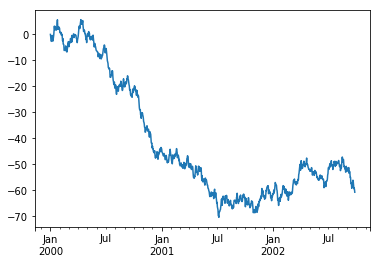

In [7]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
ts = ts.cumsum()
ts.plot()

In [11]:
test = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
test.head()

2000-01-01   -1.855965
2000-01-02    0.035037
2000-01-03   -0.439338
2000-01-04    0.499997
2000-01-05    0.902537
Freq: D, dtype: float64